# e10s-addons-beta49-week1: Main analysis

(This covers data from 2016-08-03 to 2016-08-13 on Beta 49)

## Data processing

In [1]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.plotly as py
import IPython
import pyspark.sql.functions as fun
from pyspark.sql import Row

from __future__ import division
from moztelemetry.spark import get_pings, get_one_ping_per_client, get_pings_properties
from montecarlino import grouped_permutation_test

%pylab inline
IPython.core.pylabtools.figsize(16, 7)

/home/hadoop/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Unable to parse whitelist (/home/hadoop/anaconda2/lib/python2.7/site-packages/moztelemetry/histogram-whitelists.json). Assuming all histograms are acceptable.
Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.defaultParallelism

128

In [23]:
def chi2_distance(xs, ys, eps = 1e-10, normalize = True):
    """ The comparison metric for histograms. """
    histA = xs.sum(axis=0)
    histB = ys.sum(axis=0)
    
    if normalize:
        histA = histA/histA.sum()
        histB = histB/histB.sum()
    
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])

    return d

def median_diff(xs, ys):
    return np.median(xs) - np.median(ys)

def compare_histogram(histogram, e10s, none10s, include_diff = True):
    """ Compare an e10s histogram to a non-e10s one, and graph the results.
        
        Plots the two histograms overlaid on the same graph, and prints a p-value
        for testing whether they are different. If 'include_diff' is True, also
        draw a plot of the frequency differences for each bin.
    """
    # Normalize individual histograms
    e10s = e10s.map(lambda x: x/x.sum())
    none10s = none10s.map(lambda x: x/x.sum())
    
    pvalue = grouped_permutation_test(chi2_distance, [e10s, none10s], num_samples=100)
    
    eTotal = e10s.sum()
    nTotal = none10s.sum()
    
    eTotal = 100*eTotal/eTotal.sum()
    nTotal = 100*nTotal/nTotal.sum()
    
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.3)
    
    nrows = 2 if include_diff else 1
    ax = fig.add_subplot(nrows, 1, 1)
    ax2 = ax.twinx()
    width = 0.4
    ylim = max(eTotal.max(), nTotal.max())
        
    eTotal.plot(kind="bar", alpha=0.5, color="green", label="e10s", ax=ax, width=width, position=0, ylim=(0, ylim + 1))
    nTotal.plot(kind="bar", alpha=0.5, color="blue", label="non e10s", ax=ax2, width=width, position=1, grid=False, ylim=ax.get_ylim())
        
    ax.legend(ax.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0],
              ["e10s ({} samples".format(len(e10s)), "non e10s ({} samples)".format(len(none10s))])

    # If there are more than 100 labels, hide every other one so we can still read them
    if len(ax.get_xticklabels()) > 100:
        for label in ax.get_xticklabels()[::2]:
            label.set_visible(False)
    
    plt.title(histogram)
    #plt.xlabel(histogram)
    plt.ylabel("Frequency %")
    
    if include_diff:
        fig.add_subplot(2, 1, 2)
        enDiff = eTotal - nTotal
        enDiff.plot(kind="bar")
        
        plt.title("e10s/non-e10s difference (more e10s in bucket when > 0)")
        #plt.xlabel(histogram)
        plt.ylabel("Diff in frequency %")
    
    plt.show()
        
    print "The probability that the distributions for {} are differing by chance is {:.2f}.".format(histogram, pvalue)

def normalize_uptime_hour(frame):
    """ Convert metrics to rates per hour of uptime. """
    frame = frame[frame["payload/simpleMeasurements/totalTime"] > 60]
    frame = 60 * 60 * frame.apply(lambda x: x / frame["payload/simpleMeasurements/totalTime"]) # Metric per hour
    frame.drop('payload/simpleMeasurements/totalTime', axis=1, inplace=True)
    return frame
    
def compare_e10s_count_histograms(pings, cohort_sizes = {}, *histogram_names):
    """ Read multiple count histograms from a collection of pings, and compare e10s/non-e10s for each.
    
        Treats count histograms as scalars for comparison purposes, without distinguishing between
        parent and child processes. Expects a dict containing overall cohort sizes ("e10s"/"non-e10s")
        for computing sample size proportions.
    """
    properties = histogram_names + ("payload/simpleMeasurements/totalTime", "e10s")
    frame = pd.DataFrame(get_pings_properties(pings, properties).collect())

    e10s = frame[frame["e10s"] == True]
    e10s = normalize_uptime_hour(e10s)
    
    none10s = frame[frame["e10s"] == False]
    none10s = normalize_uptime_hour(none10s)
    
    for histogram in histogram_names:
        if histogram not in none10s.columns:
            continue
        
        ## Remove the property path from the histogram name for display purposes.
        hist_name = hist_base_name(histogram)
        ## Print a header for the block of graphs, including a link to the histogram definition.
        print_with_markdown("Comparison for {} (count histogram):".format(link_to_histogram(hist_name)))
        
        e10s_hist = e10s[histogram].dropna()
        non_e10s_hist = none10s[histogram].dropna()
        
        ## Print some information on sample sizes.
        print("{} non-e10s profiles have this histogram.".format(
                sample_size_str(len(non_e10s_hist), cohort_sizes.get("non-e10s"))))
        print("{} e10s profiles have this histogram.".format(
                sample_size_str(len(e10s_hist), cohort_sizes.get("e10s"))))
        ## If either group has no data, nothing more to do.
        if len(non_e10s_hist) == 0 or len(e10s_hist) == 0:
            continue
        
        compare_scalars(hist_name + " per hour", e10s_hist, non_e10s_hist)
 
def compare_e10s_histograms(pings, cohort_sizes = {}, *histogram_names):
    """ Read multiple histograms from a collection of pings, and compare e10s/non-e10s for each.
    
        Outputs separate comparisons for parent process, child processes, and merged histograms.
        Expects a dict containing overall cohort sizes ("e10s"/"non-e10s") for computing sample
        size proportions.
    """
    ## Load histogram data from the ping set, separating parent & child processes for e10s.
    frame = pd.DataFrame(get_pings_properties(pings, histogram_names + ("e10s",) , with_processes=True).collect())
    e10s = frame[frame["e10s"] == True]
    none10s = frame[frame["e10s"] == False]
    
    for histogram in histogram_names:
        if histogram not in none10s.columns:
            continue
        
        ## Remove the property path from the histogram name for display purposes.
        hist_name = hist_base_name(histogram)
        ## Print a header for the block of graphs, including a link to the histogram definition.
        print_with_markdown("Comparison for {}:".format(link_to_histogram(hist_name)))
        
        ## Compare the main histogram for non-e10s against each of 3 for e10s.
        hist_data = {
            "non_e10s": none10s[histogram],
            "e10s_merged": e10s[histogram],
            "e10s_parent": e10s[histogram + "_parent"],
            "e10s_children": e10s[histogram + "_children"]
        }
        for htype in hist_data:
            hist_data[htype] = hist_data[htype].dropna()
        
        ## Print some information on sample sizes.
        sample_sizes = { htype: len(hdata) for htype, hdata in hist_data.iteritems() }
        print("{} non-e10s profiles have this histogram.".format(
                sample_size_str(sample_sizes["non_e10s"], cohort_sizes.get("non-e10s"))))
        print("{} e10s profiles have this histogram.".format(
                sample_size_str(sample_sizes["e10s_merged"], cohort_sizes.get("e10s"))))
        ## If either group has no data, nothing more to do.
        if sample_sizes["non_e10s"] == 0 or sample_sizes["e10s_merged"] == 0:
            continue
        
        print("{} e10s profiles have the parent histogram.".format(
                sample_size_str(sample_sizes["e10s_parent"], cohort_sizes.get("e10s"))))
        print("{} e10s profiles have the children histogram.".format(
                sample_size_str(sample_sizes["e10s_children"], cohort_sizes.get("e10s"))))
        
        has_parent = sample_sizes["e10s_parent"] > 0
        has_children = sample_sizes["e10s_children"] > 0
        
        ## Compare merged histograms, unless e10s group has either no parents or no children.
        if has_children and has_parent:
            compare_histogram(hist_name + " (e10s merged)", hist_data["e10s_merged"], hist_data["non_e10s"])
        
        if has_parent:
            compare_histogram(hist_name + " (parent)", hist_data["e10s_parent"], hist_data["non_e10s"])

        if has_children:
            compare_histogram(hist_name + " (children)", hist_data["e10s_children"], hist_data["non_e10s"])

def compare_scalars(metric, *groups):
    """ Prints the median difference between the groups, together with a p-value for testing the difference. """
    print "Median difference in {} is {:.2f} (group medians were {:.2f} and {:.2f}).".format(
        metric, median_diff(*groups), np.median(groups[0]), np.median(groups[1]))
    print "The probability of this effect being purely by chance is {:.3f}.". \
        format(grouped_permutation_test(median_diff, groups, num_samples=10000))

    
def link_to_histogram(hist_name):
    """ Create a link to the histogram definition in Markdown. """
    return "[{}](https://dxr.mozilla.org/mozilla-central/search?q={}+file%3AHistograms.json&redirect=true)"\
            .format(hist_name, hist_name)

def hist_base_name(path_to_histogram):
    """ Remove any path components from histogram name.
    
        If histogram is specified as a path in the payload, with separator '/',
        remove everything but the last component (the actual name).
    """
    return path_to_histogram.rsplit("/")[-1]

## Hack to render links in code output.
from IPython.display import Markdown, display
def print_with_markdown(md_text):
    """ Print Markdown text so that it renders correctly in the cell output. """
    display(Markdown(md_text))

def sample_size_str(sample_size, cohort_size=None):
    """ Convert a sample size to a string representation, including a percentage if available. """
    if sample_size == 0:
        return "No"
    if cohort_size:
        if sample_size == cohort_size:
            return "All"
        return "{} ({:.1f}%)".format(sample_size, float(sample_size) / cohort_size * 100)
    return str(sample_size)

### Get e10s/non-e10s cohorts for the add-ons experiment

The derived dataset is computed from profiles on Beta 49 who have e10sCohort set. It contains a single record (ping) per client, which is randomly selected from among the client's pings during the date range.

In [4]:
dataset = sqlContext.read.parquet("s3://telemetry-parquet/e10s_experiment_view/e10s_addons_beta49_cohorts/v20160803_20160813/")
dataset.printSchema()

root
 |-- clientId: string (nullable = false)
 |-- e10sCohort: string (nullable = false)
 |-- creationTimestamp: string (nullable = false)
 |-- submissionDate: string (nullable = false)
 |-- documentId: string (nullable = false)
 |-- sampleId: integer (nullable = false)
 |-- buildId: string (nullable = false)
 |-- simpleMeasurements: string (nullable = false)
 |-- settings: string (nullable = false)
 |-- addons: string (nullable = false)
 |-- system: string (nullable = false)
 |-- build: string (nullable = false)
 |-- threadHangStats: string (nullable = false)
 |-- histograms: string (nullable = false)
 |-- keyedHistograms: string (nullable = false)
 |-- childPayloads: string (nullable = false)
 |-- processes: string (nullable = false)



How many records are in the overall dataset?

In [5]:
dataset.count()

2326301

What are the cohorts, and how many clients do we have in each cohort?

In [6]:
%time cohort_counts = dataset.groupby("e10sCohort").count().collect()
dataset_count = sum(map(lambda r: r["count"], cohort_counts))

def cohort_proportions(r):
    prop = r["count"] * 100.0 / dataset_count
    return (r["e10sCohort"], r["count"], "{:.2f}%".format(prop))

print("\nTotal number of clients: {}".format(dataset_count))
sorted(map(cohort_proportions, cohort_counts), key = lambda r: r[0])

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 12.3 s

Total number of clients: 2326301


[(u'addons-set2a-control', 28762, '1.24%'),
 (u'addons-set2a-test', 28890, '1.24%'),
 (u'control', 453473, '19.49%'),
 (u'disqualified', 15, '0.00%'),
 (u'disqualified-control', 679339, '29.20%'),
 (u'disqualified-test', 679175, '29.20%'),
 (u'optedIn', 2794, '0.12%'),
 (u'optedOut', 9893, '0.43%'),
 (u'test', 441768, '18.99%'),
 (u'unknown', 2123, '0.09%'),
 (u'unsupportedChannel', 69, '0.00%')]

Restrict to pings belonging to the e10s add-ons experiment.

In [7]:
## Cache the add-ons experiment pings for ease of transformation.
addons_exp_dataset = dataset.filter("e10sCohort in ('addons-set2a-test', 'addons-set2a-control')")\
    .persist(StorageLevel.MEMORY_AND_DISK_SER)

How many clients are left?

In [8]:
addons_exp_dataset.count()

57652

We want to make sure that the pings tagged into the two cohorts satisfy the basic assumptions of the experiment, as this not guaranteed. All pings should have active addons, and e10s should be enabled if and only if the ping belongs to the test cohort.

In [11]:
def e10s_status_check(settings, addons):
    """ Check whether e10s is enabled, and whether there are add-ons. """
    e10sEnabled = json.loads(settings).get("e10sEnabled")
    active_addons = json.loads(addons).get("activeAddons")
    return Row(
        e10s_enabled = bool(e10sEnabled), 
        has_addons = bool(active_addons)
    )

def bad_ping(cohort, settings, addons):
    """ e10s should be enabled iff the profile is in the test cohort, and all profiles should have active add-ons. """
    check_data = e10s_status_check(settings, addons)
    return (cohort == "addons-set2a-test") != check_data.e10s_enabled or not check_data.has_addons

## Add a Column to the DF with the outcome of the check.
## This will be used to remove any bad rows after examining them.
from pyspark.sql.types import BooleanType
status_check_udf = fun.udf(bad_ping, BooleanType())
addons_exp_dataset_check = addons_exp_dataset.withColumn("badPing",
    status_check_udf(addons_exp_dataset.e10sCohort, addons_exp_dataset.settings, addons_exp_dataset.addons))

If there are any bad pings, describe the problems and remove them from the dataset.

In [12]:
addons_exp_dataset_bad = addons_exp_dataset_check.filter(addons_exp_dataset_check.badPing)\
    .select("e10sCohort", "settings", "addons")\
    .rdd

if addons_exp_dataset_bad.isEmpty():
    print("No issues")
else:
    check_counts = addons_exp_dataset_bad\
        .map(lambda r: (r.e10sCohort, e10s_status_check(r.settings, r.addons)))\
        .countByValue()
    print("Issues:")
    for k, v in check_counts.iteritems():
        print("{}: {}".format(k, v))
    print("\nRemoving these pings from the dataset.")
    addons_exp_dataset = addons_exp_dataset_check.filter(~addons_exp_dataset_check.badPing).drop("badPing")
    print("The dataset now contains {} clients".format(addons_exp_dataset.count()))

Issues:
(u'addons-set2a-test', Row(e10s_enabled=False, has_addons=True)): 9
(u'addons-set2a-test', Row(e10s_enabled=True, has_addons=False)): 60
(u'addons-set2a-control', Row(e10s_enabled=False, has_addons=False)): 79

Removing these pings from the dataset.
The dataset now contains 57504 clients


### Transform Dataframe to RDD of pings

In [13]:
def row_2_ping(row):
    ping = {"payload": {"simpleMeasurements": json.loads(row.simpleMeasurements) if row.simpleMeasurements else {},
                        "histograms": json.loads(row.histograms) if row.histograms else {},
                        "keyedHistograms": json.loads(row.keyedHistograms) if row.keyedHistograms else {},
                        "childPayloads": json.loads(row.childPayloads) if row.childPayloads else {},
                        "threadHangStats": json.loads(row.threadHangStats)} if row.threadHangStats else {},
           "e10s": True if row.e10sCohort == "addons-set2a-test" else False,
           "system": json.loads(row.system)}
    return ping

In [14]:
def notxp(p):
    os = p.get("system", {}).get("os", {})
    return os["name"] != "Windows_NT" or os["version"] != "5.1"

subset = addons_exp_dataset.rdd.map(row_2_ping).filter(notxp)

In [15]:
def add_gecko_activity(ping):
    uptime = ping["payload"].get("simpleMeasurements", {}).get("totalTime", -1) / 60
    if uptime <= 0:
        return ping

    def get_hangs_per_minute(threads, thread_name, uptime):
        for thread in threads:
            if thread["name"] == thread_name:
                activity = thread["activity"]["values"]
                if activity:
                    histogram = pd.Series(activity.values(), index=map(int, activity.keys())).sort_index()
                    # 255 is upper bound for 128-255ms bucket.
                    return histogram[histogram.index >= 255].sum() / uptime
        return None

    threads = ping["payload"].get("threadHangStats", {})
    ping["parent_hangs_per_minute"] = get_hangs_per_minute(threads, "Gecko", uptime)

    child_payloads = ping["payload"].get("childPayloads", [])
    child_hangs_per_minute = []
    for payload in child_payloads:
        child_uptime = payload.get("simpleMeasurements", {}).get("totalTime", -1) / 60
        if child_uptime <= 0:
            continue
        child_threads = payload.get("threadHangStats", {})
        child_hangs = get_hangs_per_minute(child_threads, "Gecko_Child", child_uptime)
        if child_hangs:
            child_hangs_per_minute.append(child_hangs)

    if len(child_hangs_per_minute) > 0:
        ping["child_hangs_per_minute"] = sum(child_hangs_per_minute) / len(child_hangs_per_minute)

    return ping

subset = subset.map(add_gecko_activity)
## Cache the restructured pings to speed up the comparison computations.
subset.persist(StorageLevel.MEMORY_AND_DISK_SER)
addons_exp_dataset = addons_exp_dataset.unpersist()

How many clients are we working with at this point?

In [16]:
subset.count()

57385

Compute the remaining cohort sizes, and wrap them into the histogram comparison functions.

In [25]:
e10s_addon_cohort_sizes = {
    "non-e10s": subset.filter(lambda p: not p["e10s"]).count(),
    "e10s": subset.filter(lambda p: p["e10s"]).count()
}

def compare_histograms(pings, *histogram_names):
    return compare_e10s_histograms(pings, e10s_addon_cohort_sizes, *histogram_names)
    
def compare_count_histograms(pings, *histogram_names):
    return compare_e10s_count_histograms(pings, e10s_addon_cohort_sizes, *histogram_names)

print("Cohort sizes:")
print(" - e10s (with add-ons): {}".format(e10s_addon_cohort_sizes["e10s"]))
print(" - non-e10s (with add-ons): {}".format(e10s_addon_cohort_sizes["non-e10s"]))

Cohort sizes:
 - e10s (with add-ons): 28746
 - non-e10s (with add-ons): 28639


## 1.3 Jank

Histogram definitions: [GC_MAX_PAUSE_MS](https://dxr.mozilla.org/mozilla-central/search?q=GC_MAX_PAUSE_MS+file%3AHistograms.json&redirect=true), [CYCLE_COLLECTOR_MAX_PAUSE](https://dxr.mozilla.org/mozilla-central/search?q=CYCLE_COLLECTOR_MAX_PAUSE+file%3AHistograms.json&redirect=true), [INPUT_EVENT_RESPONSE_MS](https://dxr.mozilla.org/mozilla-central/search?q=INPUT_EVENT_RESPONSE_MS+file%3AHistograms.json&redirect=true)

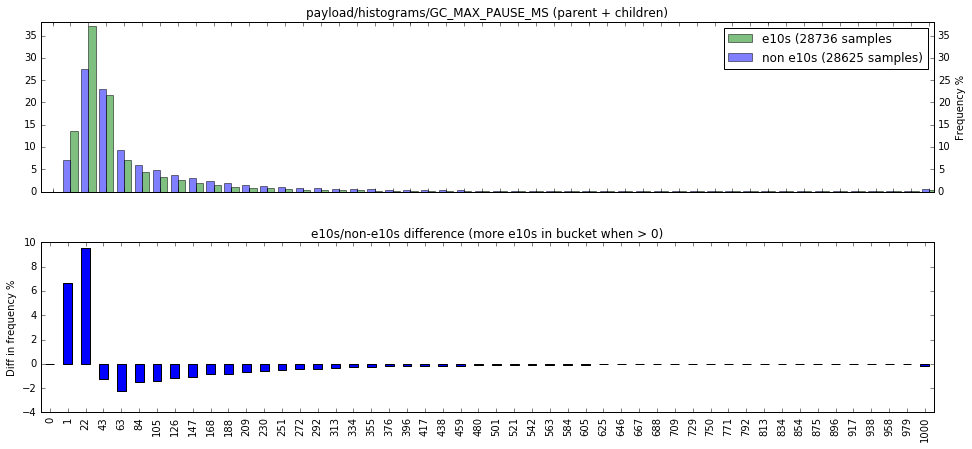

The probability that the distributions for payload/histograms/GC_MAX_PAUSE_MS (parent + children) are differing by chance is 0.00.


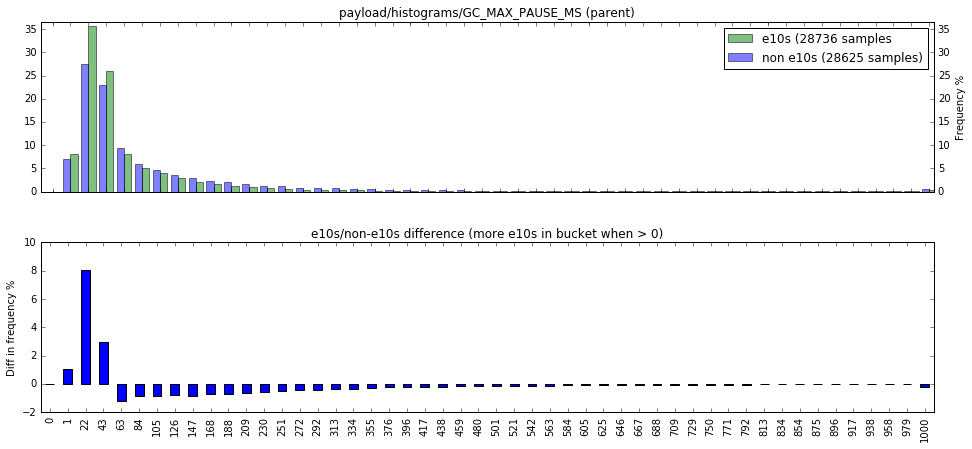

The probability that the distributions for payload/histograms/GC_MAX_PAUSE_MS (parent) are differing by chance is 0.00.


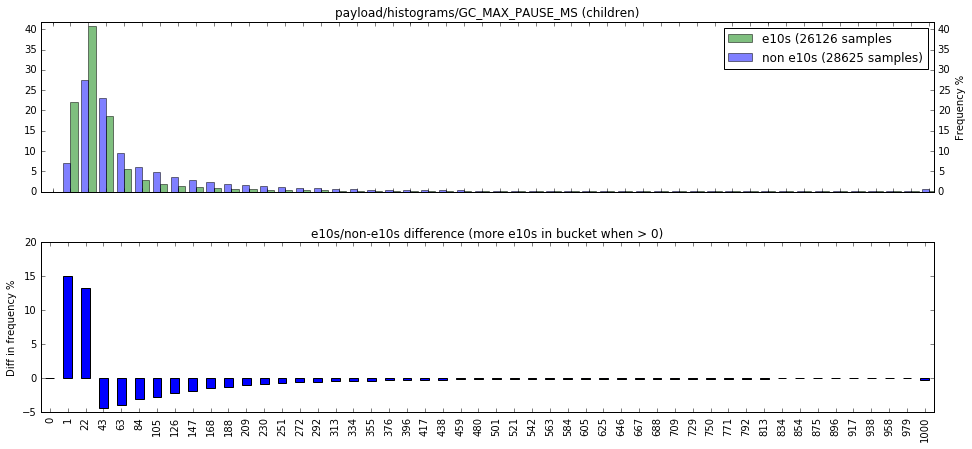

The probability that the distributions for payload/histograms/GC_MAX_PAUSE_MS (children) are differing by chance is 0.00.


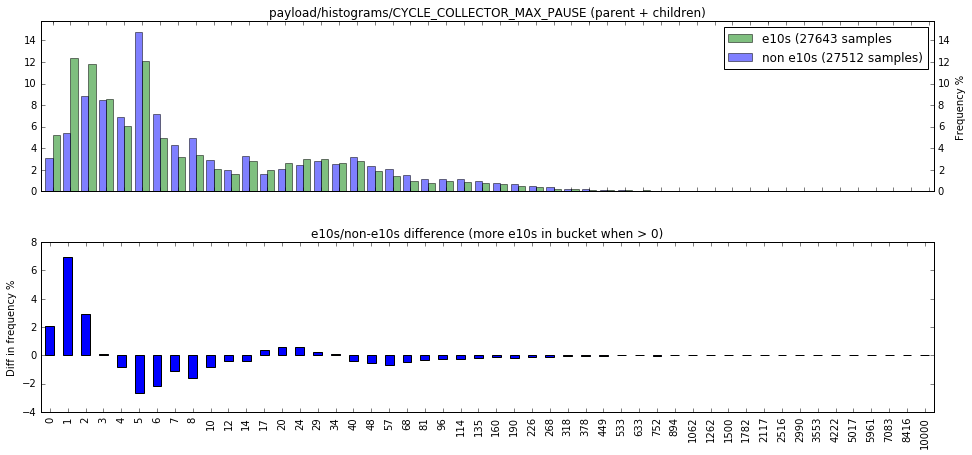

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE (parent + children) are differing by chance is 0.00.


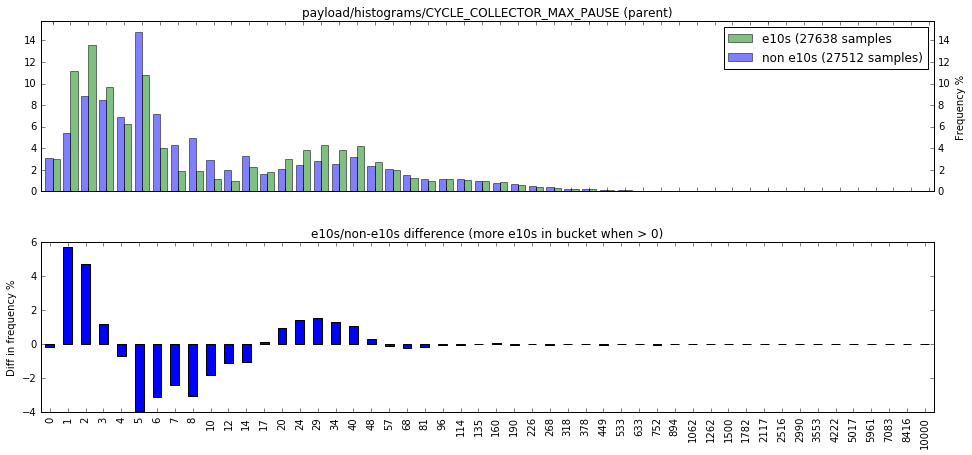

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE (parent) are differing by chance is 0.00.


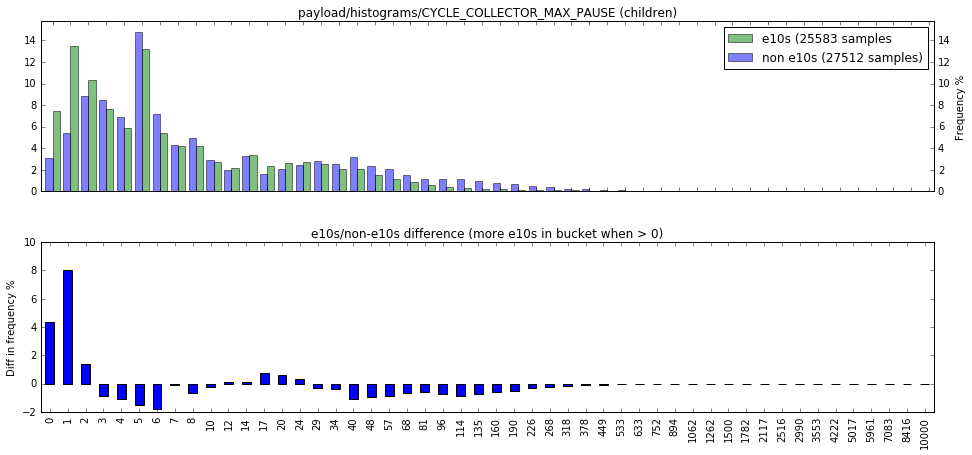

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE (children) are differing by chance is 0.00.


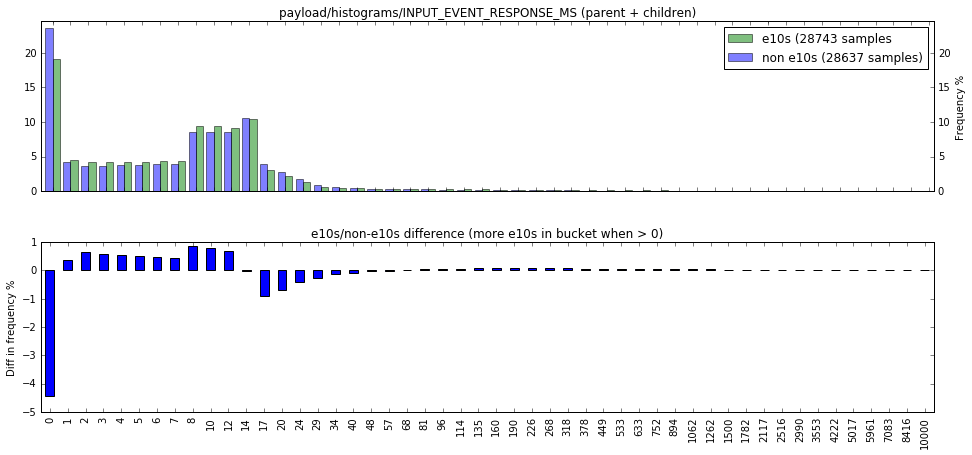

The probability that the distributions for payload/histograms/INPUT_EVENT_RESPONSE_MS (parent + children) are differing by chance is 0.00.


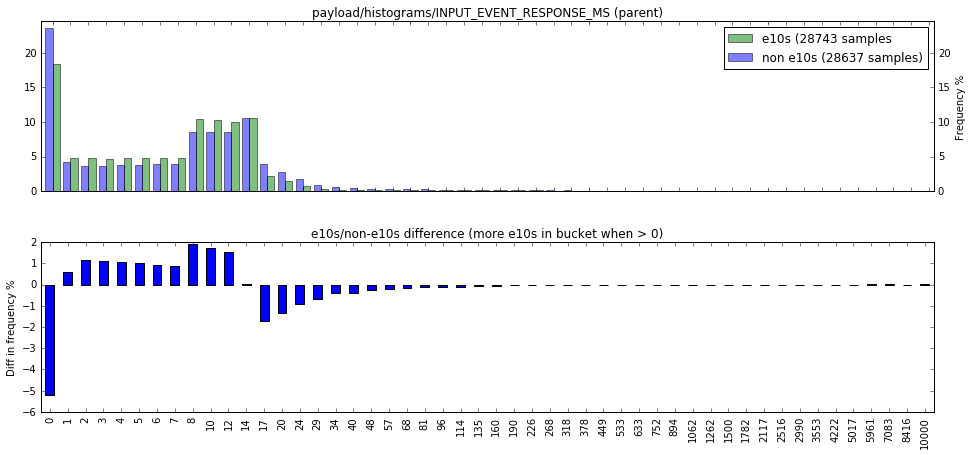

The probability that the distributions for payload/histograms/INPUT_EVENT_RESPONSE_MS (parent) are differing by chance is 0.00.


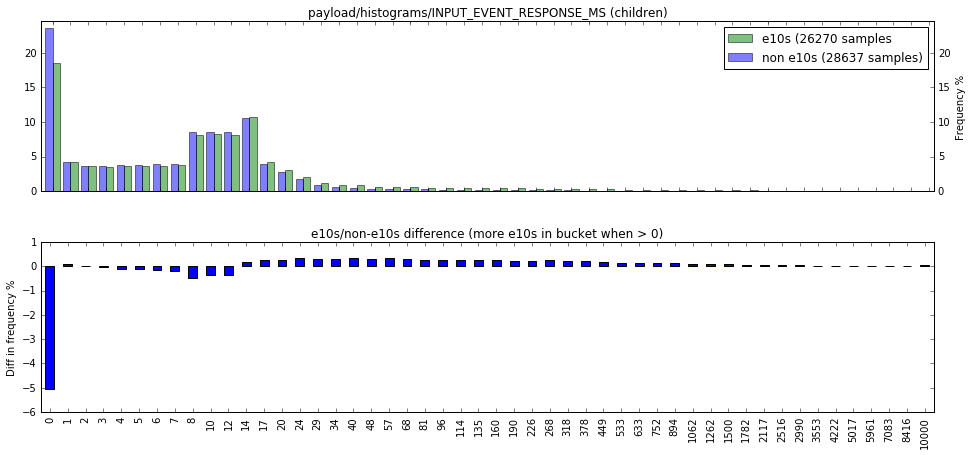

The probability that the distributions for payload/histograms/INPUT_EVENT_RESPONSE_MS (children) are differing by chance is 0.00.


In [64]:
compare_histograms(subset,  
                   "payload/histograms/GC_MAX_PAUSE_MS",
                   "payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE",
                   "payload/histograms/INPUT_EVENT_RESPONSE_MS")

## 1.4 Page load

Comparison for [FX_PAGE_LOAD_MS](https://dxr.mozilla.org/mozilla-central/search?q=FX_PAGE_LOAD_MS+file%3AHistograms.json&redirect=true):

28093 (98.1%) non-e10s profiles have this histogram.
28624 (99.6%) e10s profiles have this histogram.
28624 (99.6%) e10s profiles have the parent histogram.
No e10s profiles have the children histogram.


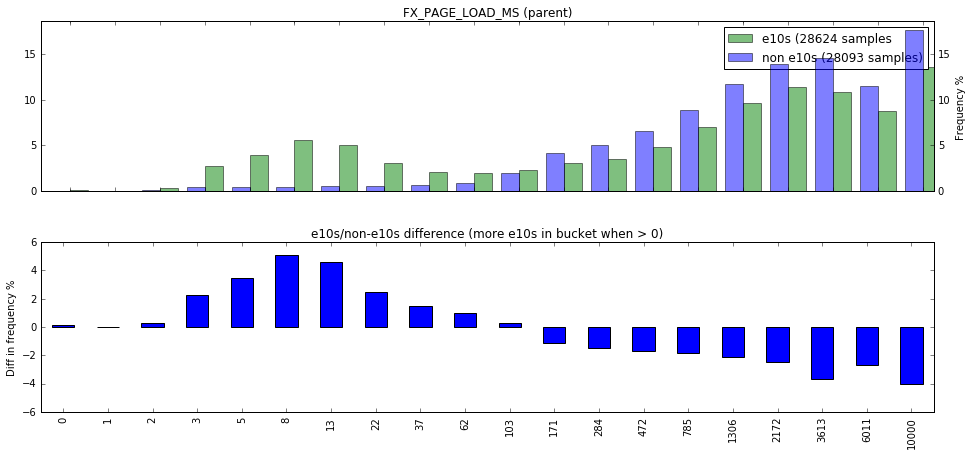

The probability that the distributions for FX_PAGE_LOAD_MS (parent) are differing by chance is 0.00.


In [26]:
compare_histograms(subset, "payload/histograms/FX_PAGE_LOAD_MS")

## 1.5 Startup/shutdown time

In [17]:
simple = pd.DataFrame(get_pings_properties(subset, [
    "payload/simpleMeasurements/firstPaint",
    "payload/simpleMeasurements/sessionRestored",
    "payload/simpleMeasurements/shutdownDuration",
    "e10s"]).collect())

eSimple = simple[simple["e10s"] == True]
nSimple = simple[simple["e10s"] == False]
len(eSimple), len(nSimple)

(28746, 28639)

In [18]:
compare_scalars("firstPaint time", eSimple["payload/simpleMeasurements/firstPaint"].dropna(), nSimple["payload/simpleMeasurements/firstPaint"].dropna())

Median difference in startup time is 60.00, (4309.00, 4249.00).
The probability of this effect being purely by chance is 0.22.


In [19]:
compare_scalars("sessionRestored time", eSimple["payload/simpleMeasurements/sessionRestored"].dropna(), nSimple["payload/simpleMeasurements/sessionRestored"].dropna())

Median difference in startup time is 100.50, (5543.00, 5442.50).
The probability of this effect being purely by chance is 0.10.


In [20]:
compare_scalars("shutdownDuration time", eSimple["payload/simpleMeasurements/shutdownDuration"].dropna(), nSimple["payload/simpleMeasurements/shutdownDuration"].dropna())

Median difference in startup time is 38.00, (1365.00, 1327.00).
The probability of this effect being purely by chance is 0.00.


## 1.6 Scrolling

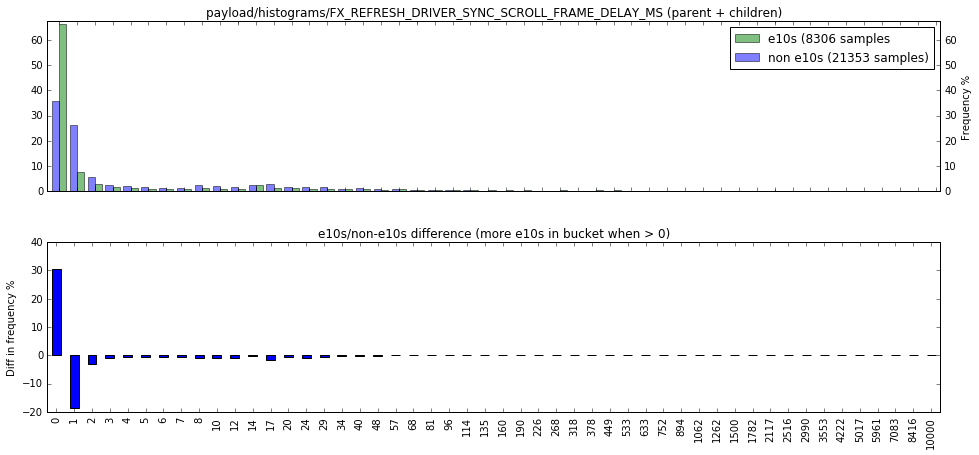

The probability that the distributions for payload/histograms/FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS (parent + children) are differing by chance is 0.00.


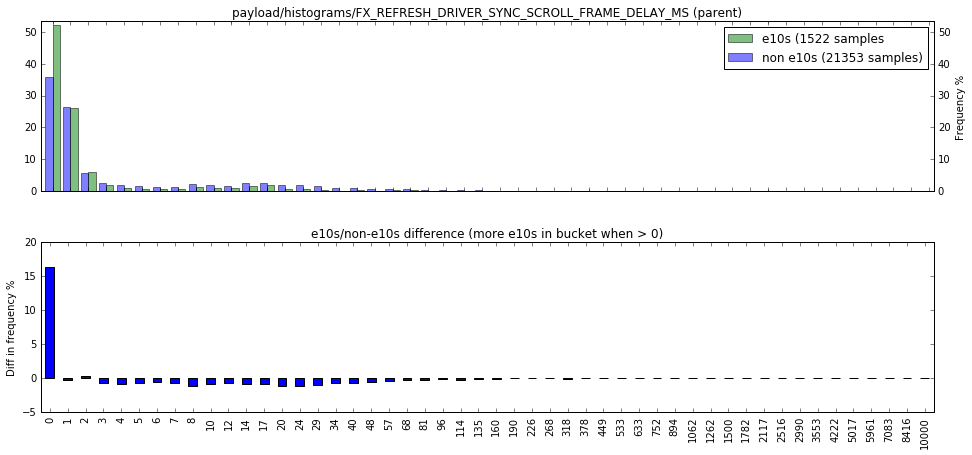

The probability that the distributions for payload/histograms/FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS (parent) are differing by chance is 0.00.


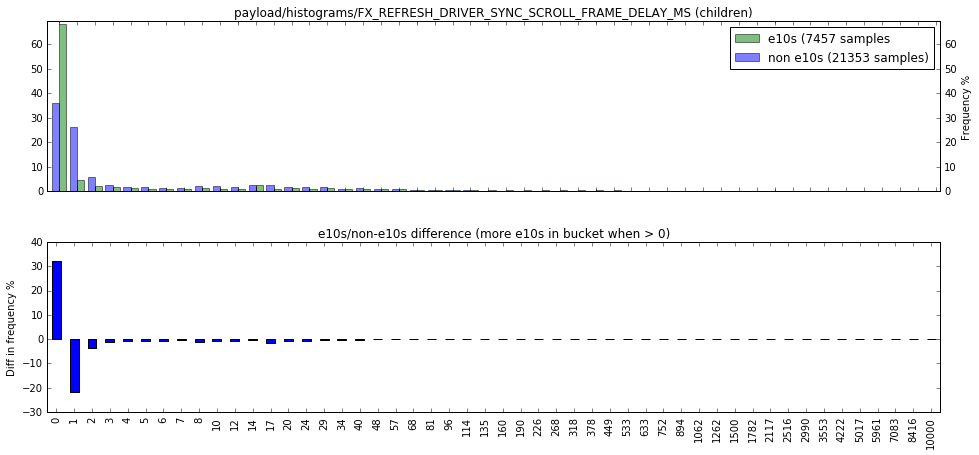

The probability that the distributions for payload/histograms/FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS (children) are differing by chance is 0.00.


In [21]:
compare_histograms(subset, "payload/histograms/FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS")

## 1.7 Plugin jank

In [130]:
compare_histograms(subset,
                   "payload/histograms/BLOCKED_ON_PLUGIN_MODULE_INIT_MS",
                   "payload/histograms/BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS",
                   "payload/histograms/BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS")

Comparison for [BLOCKED_ON_PLUGIN_MODULE_INIT_MS](https://dxr.mozilla.org/mozilla-central/search?q=BLOCKED_ON_PLUGIN_MODULE_INIT_MS+file%3AHistograms.json&redirect=true):

No non-e10s profiles have this histogram.
No e10s profiles have this histogram.


Comparison for [BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS](https://dxr.mozilla.org/mozilla-central/search?q=BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS+file%3AHistograms.json&redirect=true):

No non-e10s profiles have this histogram.
No e10s profiles have this histogram.


Comparison for [BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS](https://dxr.mozilla.org/mozilla-central/search?q=BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS+file%3AHistograms.json&redirect=true):

No non-e10s profiles have this histogram.
No e10s profiles have this histogram.


## 1.8 Memory usage

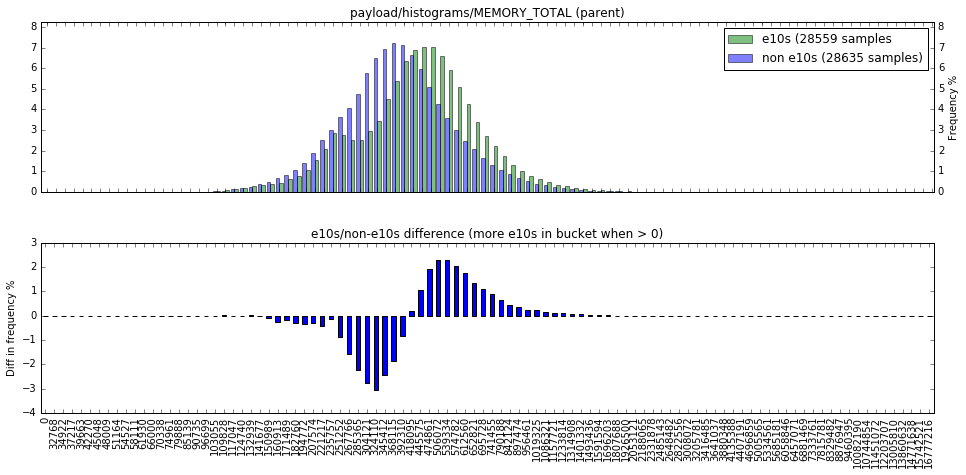

The probability that the distributions for payload/histograms/MEMORY_TOTAL (parent) are differing by chance is 0.00.


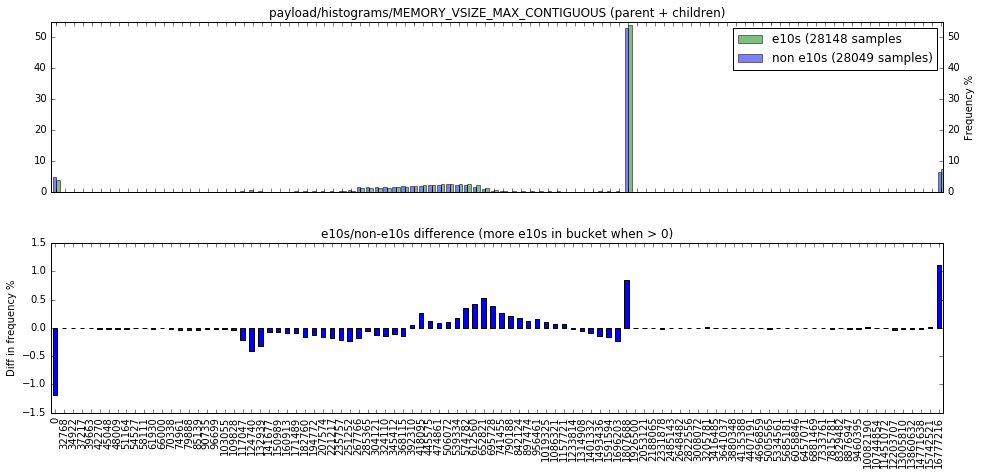

The probability that the distributions for payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS (parent + children) are differing by chance is 0.00.


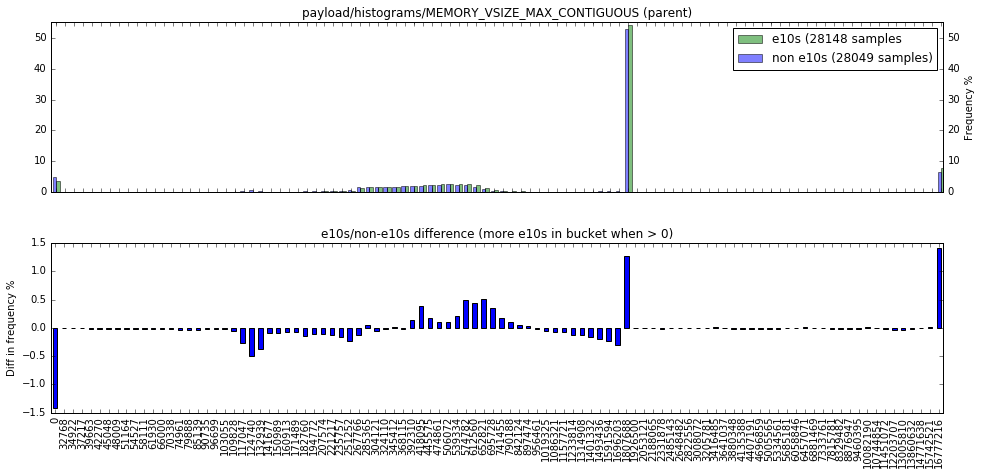

The probability that the distributions for payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS (parent) are differing by chance is 0.00.


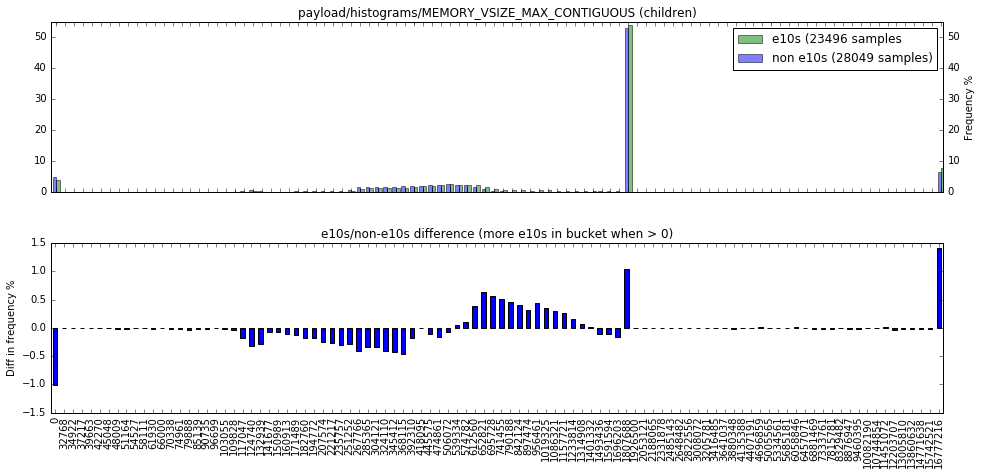

The probability that the distributions for payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS (children) are differing by chance is 0.00.


In [23]:
compare_histograms(subset,
                   "payload/histograms/MEMORY_TOTAL",
                   "payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS")

## 1.9 UI Smoothness

In [117]:
compare_histograms(subset, "payload/histograms/FX_TAB_SWITCH_TOTAL_MS")

Comparison for [FX_TAB_SWITCH_TOTAL_MS](https://dxr.mozilla.org/mozilla-central/search?q=FX_TAB_SWITCH_TOTAL_MS+file%3AHistograms.json&redirect=true):

18308 non-e10s profiles have this histogram.
No e10s profiles have this histogram.


## 1.11 Slow Scripts

In [136]:
compare_count_histograms(subset, "payload/histograms/SLOW_SCRIPT_PAGE_COUNT")

Comparison for [SLOW_SCRIPT_PAGE_COUNT](https://dxr.mozilla.org/mozilla-central/search?q=SLOW_SCRIPT_PAGE_COUNT+file%3AHistograms.json&redirect=true) (count histogram):

2015 (7.0%) non-e10s profiles have this histogram.
2314 (8.0%) e10s profiles have this histogram.
Median difference in SLOW_SCRIPT_PAGE_COUNT per hour is -0.04 (group medians were 0.31 and 0.35).
The probability of this effect being purely by chance is 0.046.


----------

# Previous metrics

## 1. Generic stuff

In [ ]:
simple = pd.DataFrame(get_pings_properties(subset, [
    "payload/simpleMeasurements/firstPaint",
    "payload/simpleMeasurements/firstLoadURI",
    "payload/simpleMeasurements/sessionRestored",
    "payload/simpleMeasurements/sessionRestoreInit",
    "payload/simpleMeasurements/shutdownDuration",
    "e10s",
    "parent_hangs_per_minute",
    "child_hangs_per_minute"]).collect())

eSimple = simple[simple["e10s"] == True]
nSimple = simple[simple["e10s"] == False]
len(eSimple), len(nSimple)

#### a) Startup time evaluation:

In [ ]:
compare_scalars("startup time", eSimple["payload/simpleMeasurements/firstPaint"].dropna(), nSimple["payload/simpleMeasurements/firstPaint"].dropna())

In [ ]:
compare_scalars("startup time", eSimple["payload/simpleMeasurements/firstLoadURI"].dropna(), nSimple["payload/simpleMeasurements/firstLoadURI"].dropna())

#### b) Shutdown time evaluation:

In [ ]:
compare_scalars("shutdown duration", eSimple["payload/simpleMeasurements/shutdownDuration"].dropna(), nSimple["payload/simpleMeasurements/shutdownDuration"].dropna())

#### c) Animation smoothness:

In [ ]:
compare_histograms(subset,
                   "payload/histograms/FX_TAB_ANIM_ANY_FRAME_INTERVAL_MS",
                   "payload/histograms/FX_TAB_ANIM_OPEN_FRAME_INTERVAL_MS",
                   "payload/histograms/FX_TAB_ANIM_OPEN_PREVIEW_FRAME_INTERVAL_MS")

#### d) Graphics:

In [ ]:
compare_histograms(subset, "payload/histograms/REFRESH_DRIVER_TICK",
                           "payload/histograms/FX_REFRESH_DRIVER_CHROME_FRAME_DELAY_MS")

## 2. Responsivness

#### a) Event processing

In [ ]:
compare_histograms(subset, "payload/histograms/EVENTLOOP_UI_ACTIVITY_EXP_MS",
                           "payload/histograms/INPUT_EVENT_RESPONSE_MS")

In [ ]:
compare_scalars("hangs over 100ms per minute (parent)",
                eSimple["parent_hangs_per_minute"].dropna(),
                nSimple["parent_hangs_per_minute"].dropna())

In [ ]:
compare_scalars("hangs over 100ms per minute (parent + child)",
                (eSimple["child_hangs_per_minute"] + eSimple["parent_hangs_per_minute"]).dropna(),
                nSimple["parent_hangs_per_minute"].dropna())

#### b) Plugins

In [ ]:
compare_count_histograms(subset, "payload/keyedHistograms/SUBPROCESS_ABNORMAL_ABORT/plugin")

#### c) Page load

In [ ]:
compare_histograms(subset, "payload/histograms/FX_PAGE_LOAD_MS")

#### d) Slow scripts

In [ ]:
compare_count_histograms(subset, "payload/histograms/SLOW_SCRIPT_NOTICE_COUNT")

In [ ]:
compare_count_histograms(subset, "payload/histograms/SLOW_SCRIPT_PAGE_COUNT")

#### e) Window open time

In [ ]:
compare_histograms(subset, "payload/histograms/FX_NEW_WINDOW_MS")

#### f) Garbage collection

In [ ]:
compare_histograms(subset, 
                   "payload/histograms/GC_MS", 
                   "payload/histograms/GC_MAX_PAUSE_MS", 
                   "payload/histograms/GC_MARK_MS", 
                   "payload/histograms/GC_SWEEP_MS", 
                   "payload/histograms/GC_MARK_ROOTS_MS")

In [ ]:
compare_histograms(subset,
                   "payload/histograms/GC_MMU_50",
                   "payload/histograms/GC_MARK_GRAY_MS",
                   "payload/histograms/GC_SLICE_MS",
                   "payload/histograms/GC_SCC_SWEEP_TOTAL_MS",
                   "payload/histograms/GC_SCC_SWEEP_MAX_PAUSE_MS")

#### g) Cycle Collector

In [ ]:
compare_histograms(subset,
                   "payload/histograms/CYCLE_COLLECTOR",
                   "payload/histograms/CYCLE_COLLECTOR_WORKER",
                   "payload/histograms/CYCLE_COLLECTOR_FULL",
                   "payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE",
                   "payload/histograms/CYCLE_COLLECTOR_TIME_BETWEEN")

## 3. Memory

#### a) Usage (bytes)

In [ ]:
compare_histograms(subset,
                   "payload/histograms/MEMORY_TOTAL",
                   "payload/histograms/MEMORY_VSIZE",
                   "payload/histograms/MEMORY_VSIZE_MAX_CONTIGUOUS",
                   "payload/histograms/MEMORY_HEAP_ALLOCATED",
                   "payload/histograms/MEMORY_JS_GC_HEAP")

In [ ]:
compare_histograms(subset,
                   "payload/histograms/MEMORY_IMAGES_CONTENT_USED_UNCOMPRESSED",
                   "payload/histograms/MEMORY_STORAGE_SQLITE")

#### c) JS compartments

In [ ]:
compare_histograms(subset,
                   "payload/histograms/MEMORY_JS_COMPARTMENTS_SYSTEM",
                   "payload/histograms/MEMORY_JS_COMPARTMENTS_USER")

#### d) Low memory events

In [ ]:
compare_histograms(subset,
                   "payload/histograms/LOW_MEMORY_EVENTS_VIRTUAL",
                   "payload/histograms/LOW_MEMORY_EVENTS_PHYSICAL")

#### e) Page faults

In [ ]:
compare_histograms(subset,
                   "payload/histograms/PAGE_FAULTS_HARD")

#### f) Ghost windows

In [ ]:
compare_histograms(subset,
                   "payload/histograms/GHOST_WINDOWS")

## 3. Other

Differences discovered by comparing all histograms (see Bug [1198638](https://bugzilla.mozilla.org/show_bug.cgi?id=1198638))

In [ ]:
compare_histograms(subset,
                   "payload/histograms/STARTUP_HTTP_CACHE_DISPOSITION_2_V2",
                   "payload/histograms/STARTUP_NETWORK_CACHE_METADATA_FIRST_READ_TIME_MS",
                   "payload/histograms/STARTUP_NETWORK_CACHE_V2_HIT_TIME_MS")

In [ ]:
compare_histograms(subset,
                   "payload/histograms/HTTP_PAGE_OPEN_TO_FIRST_FROM_CACHE_V2",
                   "payload/histograms/HTTP_PAGE_COMPLETE_LOAD_CACHED_V2",
                   "payload/histograms/HTTP_PAGE_COMPLETE_LOAD",
                   "payload/histograms/HTTP_SUB_COMPLETE_LOAD_CACHED_V2",
                   "payload/histograms/HTTP_SUB_COMPLETE_LOAD",                   
                   "payload/histograms/HTTP_SUB_REVALIDATION",
                   "payload/histograms/HTTP_SUB_OPEN_TO_FIRST_FROM_CACHE_V2")

In [ ]:
compare_histograms(subset, 
                   "payload/histograms/FX_THUMBNAILS_CAPTURE_TIME_MS",                   
                   "payload/histograms/LOCALDOMSTORAGE_GETVALUE_BLOCKING_MS",
                   "payload/histograms/FX_SESSION_RESTORE_RESTORE_WINDOW_MS",
                   "payload/histograms/FX_SESSION_RESTORE_STARTUP_ONLOAD_INITIAL_WINDOW_MS")

In [ ]:
compare_histograms(subset, 
                   "payload/histograms/IMAGE_DECODE_ON_DRAW_LATENCY",
                   "payload/histograms/IMAGE_DECODE_SPEED_GIF",
                   "payload/histograms/AUDIOSTREAM_LATER_OPEN_MS",
                   "payload/histograms/AUDIOSTREAM_FIRST_OPEN_MS")

In [ ]:
compare_histograms(subset, 
                   "payload/histograms/MEMORY_STORAGE_SQLITE",
                   "payload/histograms/BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS")

In [ ]:
IPython.core.pylabtools.figsize(32, 7)
compare_histograms(subset, 
                   "payload/histograms/CERT_VALIDATION_HTTP_REQUEST_CANCELED_TIME",
                   "payload/histograms/STARTUP_NETWORK_CACHE_METADATA_SIZE",
                   "payload/histograms/STARTUP_NETWORK_CACHE_METADATA_FIRST_READ_SIZE")
IPython.core.pylabtools.figsize(16, 7)

**bug 1226564** - please compare `HTTP_*_COMPLETE_LOAD_NET_V2`

In [ ]:
compare_histograms(subset,
                   "payload/histograms/HTTP_PAGE_COMPLETE_LOAD_NET_V2",
                   "payload/histograms/HTTP_SUB_COMPLETE_LOAD_NET_V2")

**bug 1255159** - Please look at FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS

In [ ]:
compare_histograms(subset, "payload/histograms/FX_REFRESH_DRIVER_SYNC_SCROLL_FRAME_DELAY_MS")

**bug 1273847** - Please look at SLOW_SCRIPT_NOTIFY_DELAY, SHUTDOWN_OK

In [ ]:
compare_histograms(subset, "payload/histograms/SLOW_SCRIPT_NOTIFY_DELAY")

In [ ]:
compare_histograms(subset, "payload/histograms/SHUTDOWN_OK")